<a href="https://colab.research.google.com/github/TiaApril/Smart-Watch-Scanner/blob/feature-model/SmartWasteModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks to Kaggle for providing the dataset: Link: https://www.kaggle.com/datasets/piaoya/plastic-recycling-codes

Importing the necessary libraries for use as well as unzipping the dataset to be used

In [1]:
!git clone https://github.com/TiaApril/Smart-Watch-Scanner.git

Cloning into 'Smart-Watch-Scanner'...
remote: Enumerating objects: 1296, done.
remote: Counting objects: 100% (1296/1296), done.
remote: Compressing objects: 100% (824/824), done.
remote: Total 1296 (delta 475), reused 1279 (delta 466), pack-reused 0
Receiving objects: 100% (1296/1296), 13.74 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (475/475), done.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

Training the model

In [3]:
path_to_dir = '/content/Smart-Watch-Scanner/model'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_dir,
    validation_split=0.1,
    subset="training",
    seed=42,
    batch_size=128,
    smart_resize=True,
    image_size=(256, 256)
    )
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_dir,
    validation_split=0.1,
    subset="validation",
    seed=42,
    batch_size=128,
    smart_resize=True,
    image_size=(256, 256)
    )

Found 685 files belonging to 8 classes.
Using 617 files for training.
Found 685 files belonging to 8 classes.
Using 68 files for validation.


Variable

In [4]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['1_polyethylene_PET', '2_high_density_polyethylene_PE-HD', '3_polyvinylchloride_PVC', '4_low_density_polyethylene_PE-LD', '5_polypropylene_PP', '6_polystyrene_PS', '7_other_resins', '8_no_plastic']


Model Training

In [5]:
baseModel = tf.keras.applications.MobileNetV3Large(
    input_shape=(256, 256,3),
    weights='imagenet',
    include_top=False,
    classes=numClasses
    )
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

12683000/12683000 [==============================] - 0s 0us/step


Fine-tuning the model

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.00125),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
        ),
    metrics=['accuracy']
    )

epochs = 50
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 47s 8s/step - loss: 401.9487 - accuracy: 0.1718 - val_loss: 361.2482 - val_accuracy: 0.4265
Epoch 2/50
5/5 [==============================] - 57s 11s/step - loss: 338.7122 - accuracy: 0.3647 - val_loss: 303.5925 - val_accuracy: 0.5147
Epoch 3/50
5/5 [==============================] - 38s 8s/step - loss: 283.4456 - accuracy: 0.5413 - val_loss: 252.8096 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 39s 8s/step - loss: 234.8763 - accuracy: 0.6175 - val_loss: 208.2675 - val_accuracy: 0.5147
Epoch 5/50
5/5 [==============================] - 39s 8s/step - loss: 192.4711 - accuracy: 0.6451 - val_loss: 169.5583 - val_accuracy: 0.5147
Epoch 6/50
5/5 [==============================] - 38s 8s/step - loss: 155.8194 - accuracy: 0.6840 - val_loss: 136.2033 - val_accuracy: 0.5294
Epoch 7/50
5/5 [==============================] - 38s 8s/step - loss: 124.3851 - accuracy: 0.7131 - val_loss: 107.8101 - val_accuracy: 0.5294
Epoch 8/50
5/5 [

Save the model

In [7]:
model.save('content/plastic_waste_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

Evaluation of the model

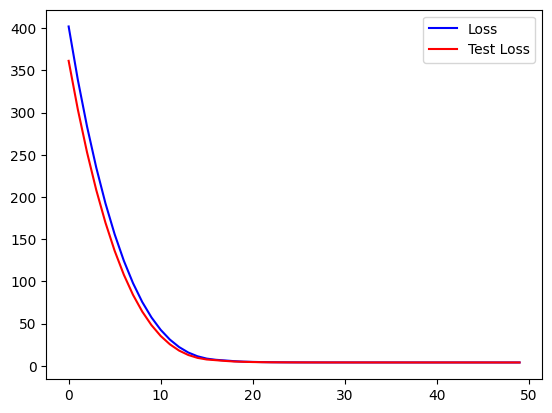

In [8]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

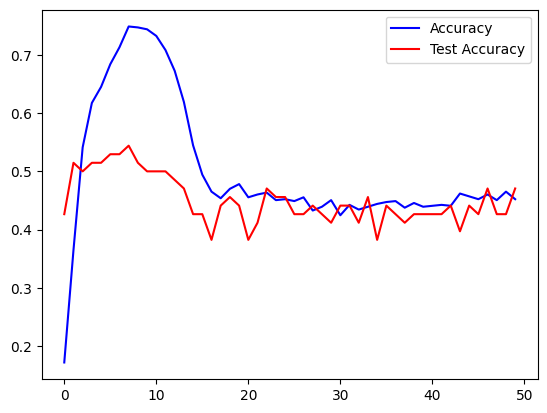

In [9]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

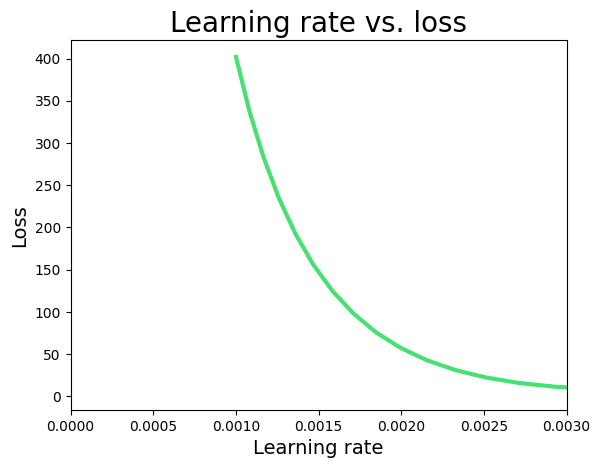

In [10]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

Creating the confusion matrix

1/1 [==============================] - 0s 62ms/step


<Figure size 1000x1000 with 0 Axes>

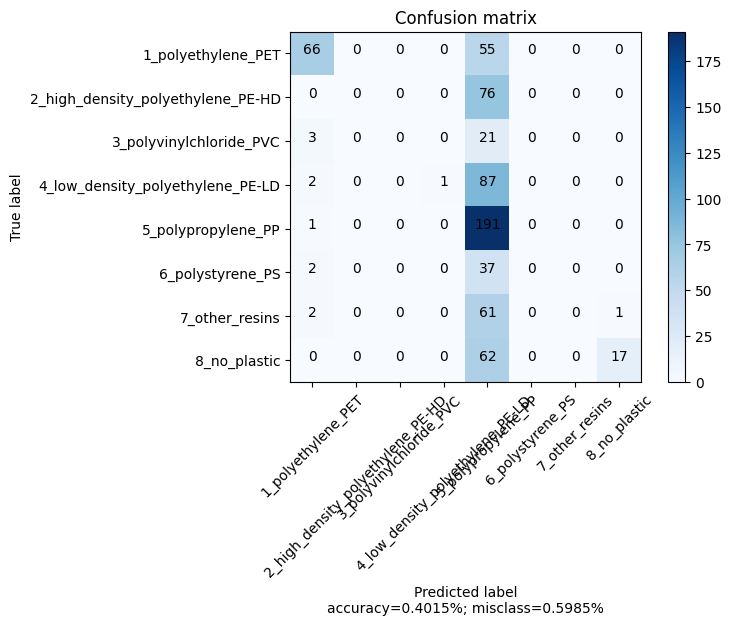

In [17]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = '/content/Smart-Watch-Scanner/model'
for directory in os.listdir(path):
  folderPath = os.path.join(path, directory)
  if os.path.isdir(folderPath):
    for filePath in os.listdir(folderPath)[:550]:
      fullPath = os.path.join(folderPath, filePath)
      if os.path.isfile(fullPath):
        try:
          img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
          img_array = tf.keras.preprocessing.image.img_to_array(img)
          img_array = tf.expand_dims(img_array, 0)

          preds = model.predict(img_array)
          true.append(classes.index(directory))
          predictions.append(np.argmax(preds))
        except:
          print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

Advanced Filter Viz

1/1 [==============================] - 0s 112ms/step


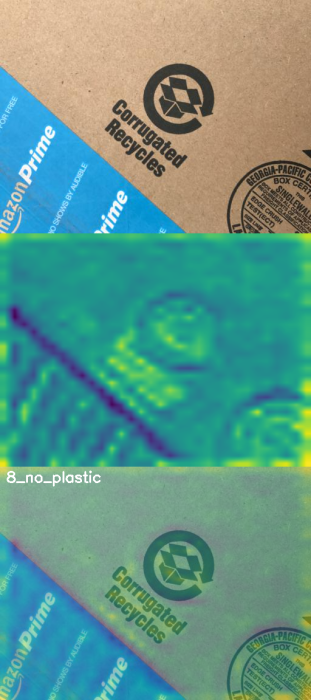

In [20]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/cardboard13.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)